In [1]:
import torch, os, platform, sys
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
!nvidia-smi

PyTorch: 2.9.0+cu126
CUDA available: True
Fri Dec  5 03:13:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shayanfazeli/heartbeat")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'heartbeat' dataset.
Path to dataset files: /kaggle/input/heartbeat


In [3]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
import matplotlib
import os


matplotlib.rcParams["figure.figsize"] = (6, 4)
plt.style.use("ggplot")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


# Dataset: Segmented and Preprocessed ECG Signals for Heartbeat

Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.

Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset. The final element of each row denotes the class to which that example belongs.

Source: https://www.kaggle.com/datasets/shayanfazeli/heartbeat/data?select=ptbdb_normal.csv

In [5]:
normal_df = pd.read_csv(f"{path}/ptbdb_normal.csv").iloc[:, :-1]
anomaly_df = pd.read_csv(f"{path}/ptbdb_abnormal.csv").iloc[:, :-1]

normal_df.head()

,1.000000000000000000e+00,9.003241658210754395e-01,3.585899472236633301e-01,5.145867168903350830e-02,4.659643396735191345e-02,1.268233358860015869e-01,1.333063244819641113e-01,1.191247999668121338e-01,1.106158867478370667e-01,1.130470037460327148e-01,...,0.000000000000000000e+00.55,0.000000000000000000e+00.56,0.000000000000000000e+00.57,0.000000000000000000e+00.58,0.000000000000000000e+00.59,0.000000000000000000e+00.60,0.000000000000000000e+00.61,0.000000000000000000e+00.62,0.000000000000000000e+00.63,0.000000000000000000e+00.64
0,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.948983,0.505265,0.004176,0.022513,0.059550,0.107298,0.110385,0.111293,0.116558,0.118192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploratory Data Analysis

In [6]:
print("Shape of Normal data", normal_df.shape)
print("Shape of Abnormal data", anomaly_df.shape)

Shape of Normal data (4045, 187)
Shape of Abnormal data (10505, 187)


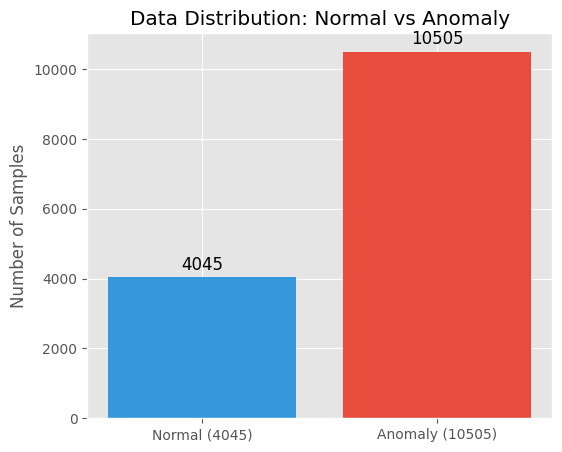

In [ ]:

counts = [len(normal_df), len(anomaly_df)]
labels = [f'Normal ({len(normal_df)})', f'Anomaly ({len(anomaly_df)})']
colors = ['#3498db', '#e74c3c']

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, counts, color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, yval, ha='center', va='bottom', fontsize=12)

plt.title("Data Distribution: Normal vs Anomaly")
plt.ylabel("Number of Samples")
plt.show()

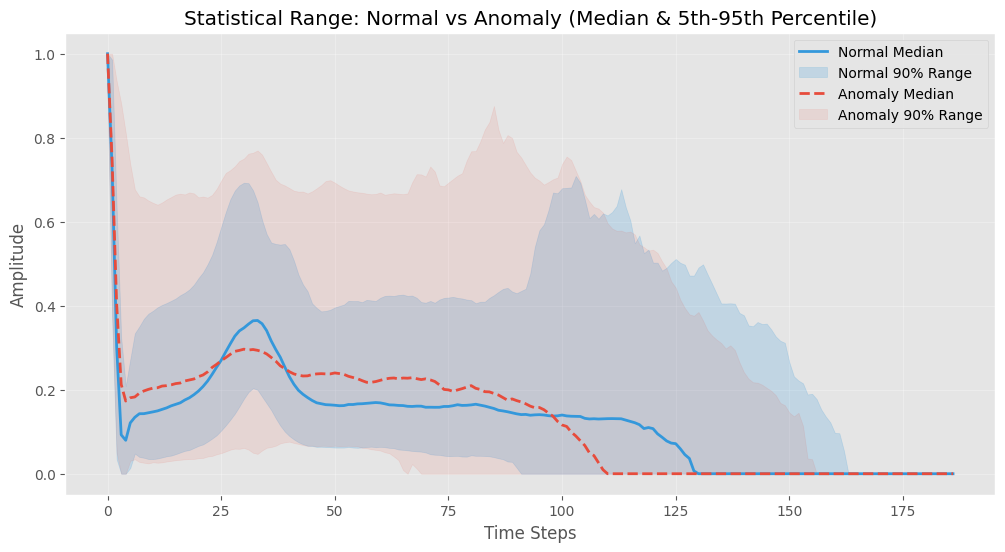

In [ ]:

def plot_percentile_range(normal, anomaly):
    plt.figure(figsize=(12, 6))

    def get_stats(df):
        median = np.nanpercentile(df, 50, axis=0)
        lower = np.nanpercentile(df, 5, axis=0)
        upper = np.nanpercentile(df, 95, axis=0)
        return median, lower, upper

    norm_mid, norm_low, norm_high = get_stats(normal)

    anom_mid, anom_low, anom_high = get_stats(anomaly)

    plt.plot(norm_mid, color='#3498db', linewidth=2, label='Normal Median')
    plt.fill_between(range(187), norm_low, norm_high, color='#3498db', alpha=0.2, label='Normal 90% Range')

    plt.plot(anom_mid, color='#e74c3c', linewidth=2, linestyle='--', label='Anomaly Median')
    plt.fill_between(range(187), anom_low, anom_high, color='#e74c3c', alpha=0.1, label='Anomaly 90% Range')

    plt.title("Statistical Range: Normal vs Anomaly (Median & 5th-95th Percentile)")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_percentile_range(normal_df, anomaly_df)

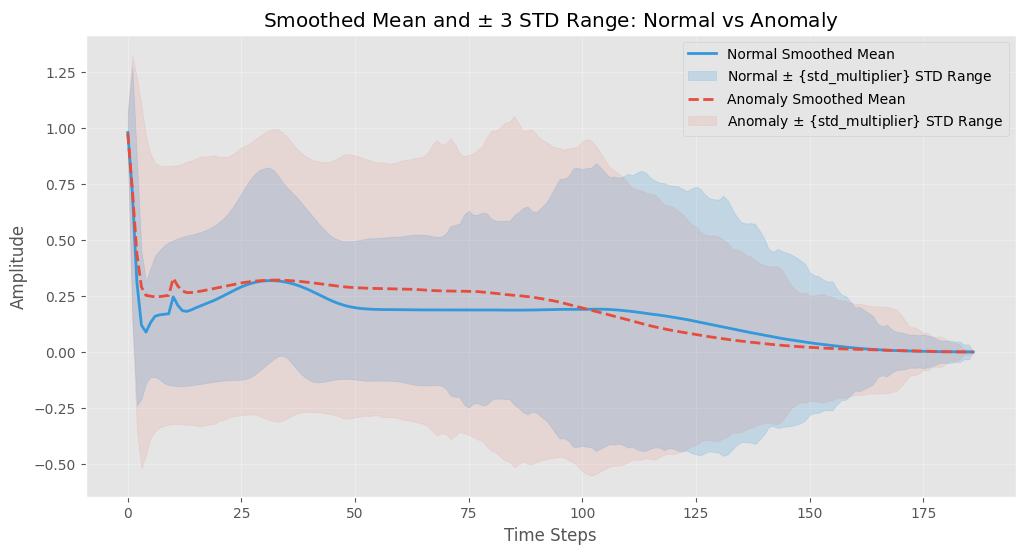

In [ ]:
time_steps = normal_df.shape[1] # 187

def calculate_smoothed_mean_stats_fixed(df, std_multiplier=3, window_size=20):

    mean_signal = df.mean(axis=0)
    std_signal = df.std(axis=0)

    smoothed_mean = mean_signal.rolling(window=window_size, center=True).mean()
    smoothed_mean = smoothed_mean.fillna(mean_signal)

    upper_bound = mean_signal + std_signal * std_multiplier
    lower_bound = mean_signal - std_signal * std_multiplier

    return smoothed_mean.values, lower_bound.values, upper_bound.values

def plot_smoothed_range(normal_df, anomaly_df, std_multiplier=3, window_size=20):
    plt.figure(figsize=(12, 6))

    time_steps_range = range(normal_df.shape[1])

    norm_mean, norm_low, norm_high = calculate_smoothed_mean_stats_fixed(
        normal_df, std_multiplier=std_multiplier, window_size=window_size
    )

    anom_mean, anom_low, anom_high = calculate_smoothed_mean_stats_fixed(
        anomaly_df, std_multiplier=std_multiplier, window_size=window_size
    )

    NORMAL_COLOR = '#3498db'

    plt.plot(time_steps_range, norm_mean, color=NORMAL_COLOR, linewidth=2, label='Normal Smoothed Mean')

    plt.fill_between(time_steps_range, norm_low, norm_high, color=NORMAL_COLOR, alpha=0.2, label=r'Normal $\pm$ {std_multiplier} STD Range')


    ANOMALY_COLOR = '#e74c3c'

    plt.plot(time_steps_range, anom_mean, color=ANOMALY_COLOR, linewidth=2, linestyle='--', label='Anomaly Smoothed Mean')

    plt.fill_between(time_steps_range, anom_low, anom_high, color=ANOMALY_COLOR, alpha=0.1, label=r'Anomaly $\pm$ {std_multiplier} STD Range')


    plt.title(r"Smoothed Mean and $\pm$ 3 STD Range: Normal vs Anomaly")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_smoothed_range(normal_df, anomaly_df)

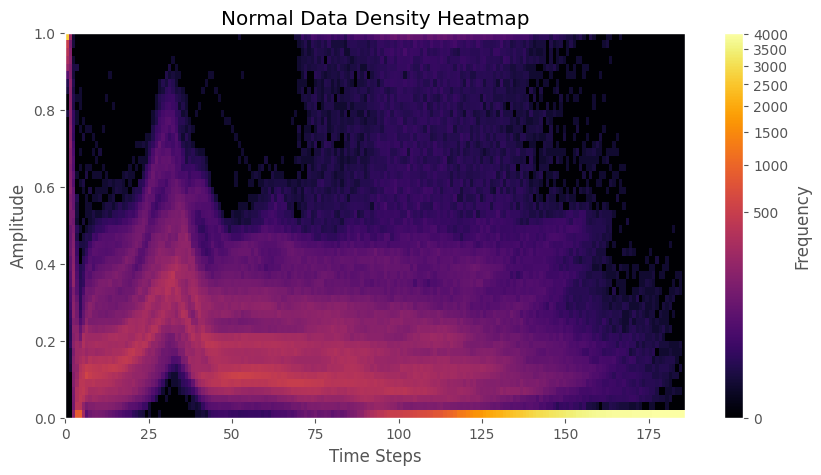

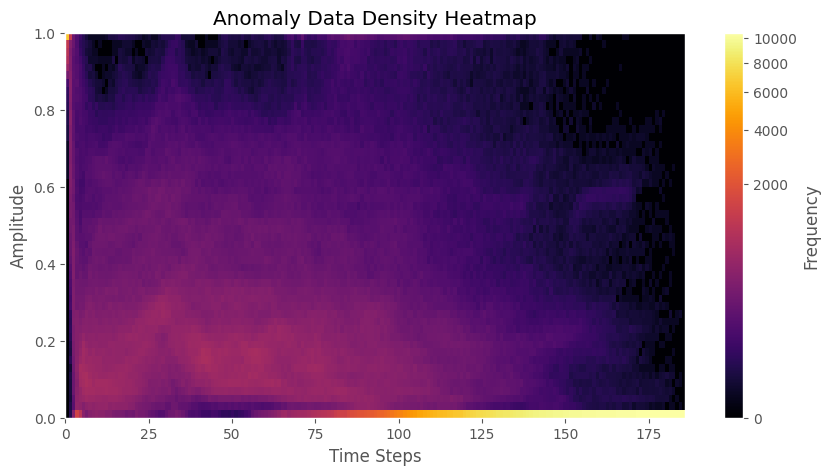

In [ ]:

import matplotlib.colors as mcolors

def plot_density_heatmap(df, title):
    x = np.tile(np.arange(187), len(df))
    y = df.values.flatten()

    plt.figure(figsize=(10, 5))
    plt.hist2d(x, y, bins=[187, 50], cmap='inferno', norm=mcolors.PowerNorm(0.3))
    plt.colorbar(label='Frequency')
    plt.title(f"{title} Density Heatmap")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.show()

plot_density_heatmap(normal_df, "Normal Data")

plot_density_heatmap(anomaly_df, "Anomaly Data")

Normal Data Range: [0.00, 1.00]
Anomaly Data Range: [0.00, 1.00]


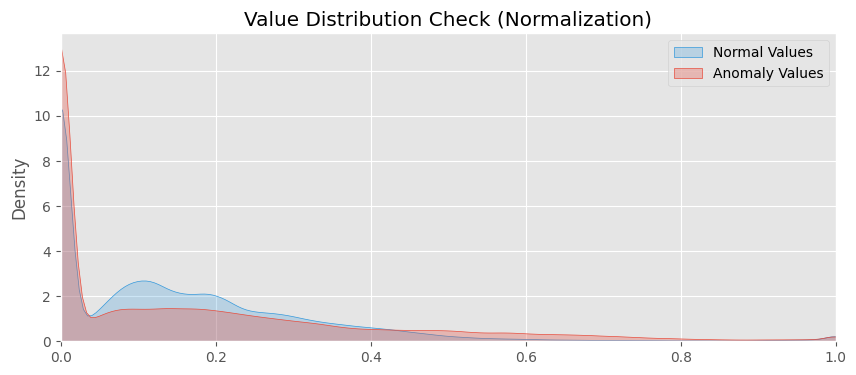

In [ ]:

print(f"Normal Data Range: [{normal_df.min().min():.2f}, {normal_df.max().max():.2f}]")
print(f"Anomaly Data Range: [{anomaly_df.min().min():.2f}, {anomaly_df.max().max():.2f}]")

plt.figure(figsize=(10, 4))
sns.kdeplot(normal_df.values.flatten(), color='#3498db', fill=True, label='Normal Values')
sns.kdeplot(anomaly_df.values.flatten(), color='#e74c3c', fill=True, label='Anomaly Values', alpha=0.3)
plt.title("Value Distribution Check (Normalization)")
plt.xlim(0, 1)
plt.legend()
plt.show()

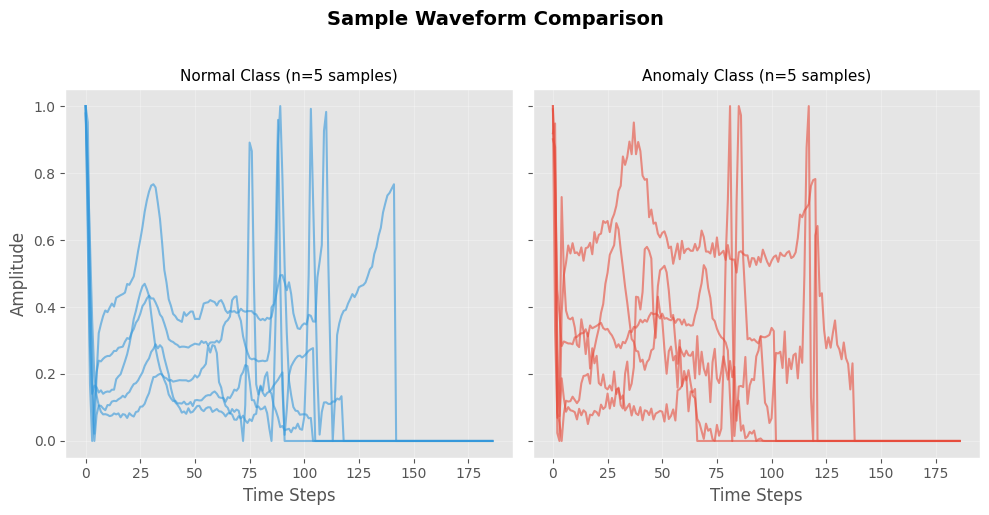

In [ ]:

def plot_sample_overlay(normal_df, anomaly_df, n_samples=5, title="Sample Waveform Comparison"):


    n_normal = min(n_samples, len(normal_df))
    n_anomaly = min(n_samples, len(anomaly_df))

    normal_indices = np.random.randint(0, len(normal_df), n_normal)
    anomaly_indices = np.random.randint(0, len(anomaly_df), n_anomaly)

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

    NORMAL_COLOR = '#3498db'

    for i, idx in enumerate(normal_indices):
        label = f"Sample {idx}" if i == 0 else None 
        ax[0].plot(normal_df.iloc[idx, :].values, color=NORMAL_COLOR, alpha=0.6, linewidth=1.5, label=label)

    ax[0].set_title(f"Normal Class (n={n_normal} samples)", fontsize=11)
    ax[0].set_xlabel("Time Steps")
    ax[0].set_ylabel("Amplitude")
    ax[0].grid(True, alpha=0.3)


    ANOMALY_COLOR = '#e74c3c'

    for i, idx in enumerate(anomaly_indices):
        label = f"Sample {idx}" if i == 0 else None
        ax[1].plot(anomaly_df.iloc[idx, :].values, color=ANOMALY_COLOR, alpha=0.6, linewidth=1.5, label=label)

    ax[1].set_title(f"Anomaly Class (n={n_anomaly} samples)", fontsize=11)
    ax[1].set_xlabel("Time Steps")
    ax[1].grid(True, alpha=0.3)
    # ax[1].legend(loc='upper right', fontsize=9)

    plt.suptitle(title, fontsize=14, y=1.02, fontweight='bold')
    plt.tight_layout()
    plt.show()


plot_sample_overlay(normal_df, anomaly_df, n_samples=5)

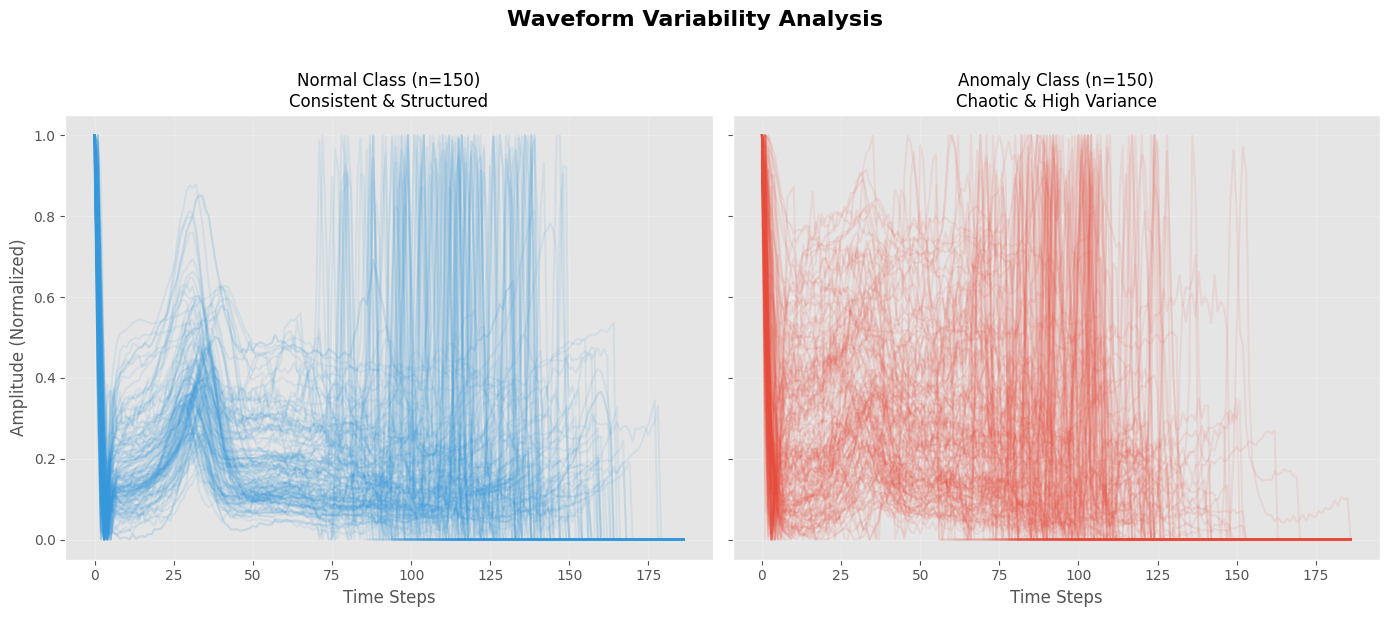

In [ ]:

def plot_waveform_overlay(normal, anomaly, n_samples=150, title="Waveform Variability Analysis"):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(14, 6))


    normal_indices = np.random.randint(0, len(normal), n_samples)

    for i in normal_indices:
        ax[0].plot(normal.iloc[i, :].values, color='#3498db', alpha=0.1, linewidth=1.5)

    ax[0].set_title(f"Normal Class (n={n_samples})\nConsistent & Structured", fontsize=12)
    ax[0].set_xlabel("Time Steps")
    ax[0].set_ylabel("Amplitude (Normalized)")
    ax[0].grid(True, alpha=0.2) 

    anomaly_indices = np.random.randint(0, len(anomaly), n_samples)

    for i in anomaly_indices:
        ax[1].plot(anomaly.iloc[i, :].values, color='#e74c3c', alpha=0.1, linewidth=1.5)

    ax[1].set_title(f"Anomaly Class (n={n_samples})\nChaotic & High Variance", fontsize=12)
    ax[1].set_xlabel("Time Steps")
    ax[1].grid(True, alpha=0.2)

    plt.suptitle(title, fontsize=16, y=1.02, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_waveform_overlay(normal_df, anomaly_df, n_samples=150)

# Normal-only Scaler

In [ ]:
normal = normal_df.to_numpy().astype(np.float64)
anomaly = anomaly_df.to_numpy().astype(np.float64)

In [ ]:

from sklearn.model_selection import train_test_split

X_train, X_temp = train_test_split(
    normal,
    test_size=0.30,
    random_state=45,
    shuffle=True
)

X_validate, X_test = train_test_split(
    X_temp,
    test_size=0.50,   # 50% of 30% = 15%
    random_state=45,
    shuffle=True
)

print("Train:", X_train.shape)
print("Valid:", X_validate.shape)
print("Test :", X_test.shape)

Train: (2831, 187)
Valid: (607, 187)
Test : (607, 187)


In [ ]:
# 3. Normal-only Scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)  

X_train_scaled    = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled     = scaler.transform(X_test)
anomaly_scaled    = scaler.transform(anomaly)

print("Scaling completed.")


Scaling completed.


In [ ]:

class AnomalyDetectionDataset(Dataset):
    """
    PyTorch Dataset for Autoencoder Anomaly Detection.
    X = Y = input itself.
    """
    def __init__(self, np_array):
        self.data = torch.from_numpy(np_array).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        return x, x  

In [ ]:
train_dataset    = AnomalyDetectionDataset(X_train_scaled)
validate_dataset = AnomalyDetectionDataset(X_validate_scaled)
test_dataset     = AnomalyDetectionDataset(X_test_scaled)
anomaly_dataset  = AnomalyDetectionDataset(anomaly_scaled)

In [ ]:
train_dataset    = AnomalyDetectionDataset(X_train)
validate_dataset = AnomalyDetectionDataset(X_validate)
test_dataset     = AnomalyDetectionDataset(X_test)
anomaly_dataset  = AnomalyDetectionDataset(anomaly)

In [20]:
# 6. DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validate_loader = DataLoader(validate_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
anomaly_loader = DataLoader(anomaly_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train batches:", len(train_loader))
print("Valid batches:", len(validate_loader))
print("Test batches :", len(test_loader))
print("Anomaly batches:", len(anomaly_loader))

Train batches: 45
Valid batches: 10
Test batches : 10
Anomaly batches: 165


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Normal-only Data Augmentation

In [ ]:
import random

def augment_ecg(batch, jitter_std=0.01, scale_std=0.05, max_shift=2):
    """
    batch: (B, 188)
    """
    B, T = batch.shape

    jitter = torch.randn_like(batch) * jitter_std
    batch = batch + jitter

    # scale = 1.0 + torch.randn(B, 1, device=batch.device) * scale_std
    scale = 1.0 + torch.randn_like(batch[:, :1]) * scale_std
    batch = batch * scale

    shift = random.randint(-max_shift, max_shift)
    batch = torch.roll(batch, shifts=shift, dims=1)

    return batch


# CNN Autoencoder Model

In [ ]:
# class ECG_AutoEncoder_V2(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # ---- Encoder ----
#         self.encoder = nn.Sequential(
#             nn.Conv1d(1, 64, 7, padding=3),
#             nn.BatchNorm1d(64),
#             nn.ReLU(),

#             nn.Conv1d(64, 128, 7, padding=3),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),

#             nn.Conv1d(128, 256, 7, padding=3),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#         )

#         # Bottleneck: Reduce the dimensionality to avoid making it too large.
#         self.bottleneck = nn.Sequential(
#             nn.Conv1d(256, 64, kernel_size=1),
#             nn.ReLU()
#         )

#         # ---- Decoder ----
#         self.decoder = nn.Sequential(
#             nn.Conv1d(64, 128, 7, padding=3),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),

#             nn.Conv1d(128, 64, 7, padding=3),
#             nn.BatchNorm1d(64),
#             nn.ReLU(),

#             nn.Conv1d(64, 1, 7, padding=3),
#         )

#     def forward(self, x):
#         x = x.unsqueeze(1)  # (B, 187) -> (B,1,187)
#         x = self.encoder(x)
#         x = self.bottleneck(x)
#         x = self.decoder(x)
#         return x.squeeze(1) # (B,1,187) -> (B,187)


In [23]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = ECG_AutoEncoder_V2().to(device)

In [ ]:
torch.manual_seed(1024)

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()

        # --- 1. Encoder ---
        # Conv1d Input: (Batch, Channel=1, Length=input_dim)
        self.encoder = nn.Sequential(
            # Layer 1: Conv1D(128, 3) + BN + MaxPool
            nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),

            # Layer 2: Conv1D(128, 3) + BN + MaxPool
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),

            # Layer 3: Conv1D(latent_dim, 3) + BN + MaxPool
            nn.Conv1d(in_channels=128, out_channels=latent_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        # --- 2. Decoder Conv part (do not change the length, only the channel) ---
        self.decoder_conv = nn.Sequential(
            # Layer 1: Transpose(latent_dim -> latent_dim)
            nn.ConvTranspose1d(in_channels=latent_dim, out_channels=latent_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(),

            # Layer 2: Transpose(latent_dim -> 128)
            nn.ConvTranspose1d(in_channels=latent_dim, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            # Layer 3: Transpose(128 -> 128)
            nn.ConvTranspose1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )

        # --- 3. Automatically calculate the Flatten size after "encoder + decoder_conv" ---
        self._flatten_size = self._get_flatten_size(input_dim, latent_dim)

        self.decoder_dense = nn.Linear(self._flatten_size, input_dim)

        self.final_activation = nn.Identity()

    def _get_flatten_size(self, input_dim, latent_dim):

        dummy_input = torch.zeros(1, 1, input_dim)   # shape: [1, 1, 187]
        with torch.no_grad():
            encoded = self.encoder(dummy_input)      # [1, latent_dim, L_enc]
            decoded = self.decoder_conv(encoded)     # [1, 128, L_dec]
        return decoded.view(1, -1).size(1)

    def forward(self, x):
        # x shape: [Batch, 187]

        # 1. Reshape for Conv1d: [Batch, 187] -> [Batch, 1, 187]
        x = x.unsqueeze(1)

        # 2. Encoder: [B, 1, 187] -> [B, latent_dim, L_enc]
        encoded = self.encoder(x)

        # 3. Decoder Conv Block: [B, latent_dim, L_enc] -> [B, 128, L_dec]
        decoded = self.decoder_conv(encoded)

        # 4. Flatten: [B, 128, L_dec] -> [B, flatten_size]
        decoded = decoded.view(decoded.size(0), -1)

        # 5. Dense to input_dim
        reconstructed = self.decoder_dense(decoded)

        reconstructed = self.final_activation(reconstructed)

        return reconstructed


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = 187
latent_dim = 32

model = AutoEncoder(input_dim=input_dim, latent_dim=latent_dim).to(device)


In [26]:
def train_model(model, train_loader, val_loader, epochs=20, lr=0.001, use_augmentation=True):

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.L1Loss()

    train_history = []
    val_history = []

    best_val_loss = float('inf')

    for epoch in range(epochs):

        # --- Training ---
        model.train()
        train_loss = 0.0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)

            if use_augmentation:
                data_aug = augment_ecg(data)
            else:
                data_aug = data

            optimizer.zero_grad()
            outputs = model(data_aug)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)


        # --- Validation ---
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for val_batch, _ in val_loader:
                val_batch = val_batch.to(device)
                val_out = model(val_batch)
                loss = criterion(val_out, val_batch)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)


        # --- Print ---
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

        # --- Save best model ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_autoencoder.pth")
            print("  >>> Model Saved!")

        # --- Store history ---
        train_history.append(avg_train_loss)
        val_history.append(avg_val_loss)

    return train_history, val_history


In [27]:
# train_model(model, train_loader, epochs=50, use_augmentation=True)

# train_model(model, train_loader, validate_loader, epochs=50, use_augmentation=True)

train_history, val_history = train_model(model, train_loader, validate_loader, epochs=50, use_augmentation=True)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/50] Train Loss: 0.322493 | Val Loss: 0.098830
  >>> Model Saved!
Epoch [2/50] Train Loss: 0.083631 | Val Loss: 0.074601
  >>> Model Saved!
Epoch [3/50] Train Loss: 0.068761 | Val Loss: 0.060690
  >>> Model Saved!
Epoch [4/50] Train Loss: 0.057512 | Val Loss: 0.050289
  >>> Model Saved!
Epoch [5/50] Train Loss: 0.046719 | Val Loss: 0.043989
  >>> Model Saved!
Epoch [6/50] Train Loss: 0.044025 | Val Loss: 0.038534
  >>> Model Saved!
Epoch [7/50] Train Loss: 0.041705 | Val Loss: 0.034380
  >>> Model Saved!
Epoch [8/50] Train Loss: 0.040829 | Val Loss: 0.044736
Epoch [9/50] Train Loss: 0.037974 | Val Loss: 0.030735
  >>> Model Saved!
Epoch [10/50] Train Loss: 0.033953 | Val Loss: 0.027445
  >>> Model Saved!
Epoch [11/50] Train Loss: 0.034253 | Val Loss: 0.028253
Epoch [12/50] Train Loss: 0.033818 | Val Loss: 0.030442
Epoch [13/50] Train Loss: 0.034195 | Val Loss: 0.029359
Epoch [14/50] Train Loss: 0.033354 | Val Loss: 0.025391
  >>> Model Saved!
Epoch [15/50] Train Loss: 0.030543 

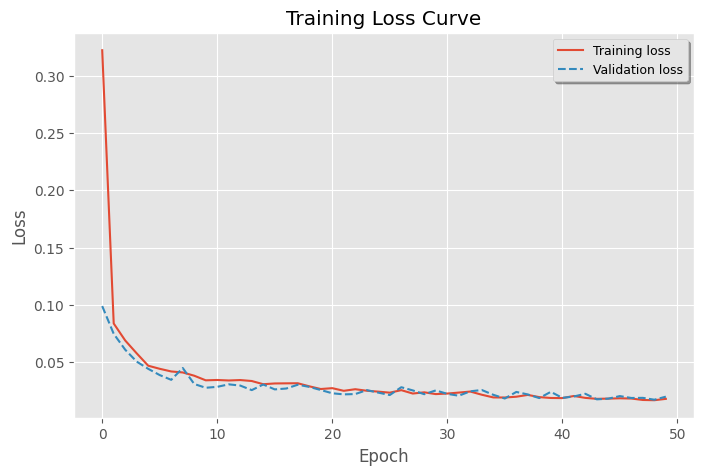

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train_history, label="Training loss")
plt.plot(val_history, label="Validation loss", linestyle="--")
plt.legend(shadow=True, frameon=True, facecolor="inherit", fontsize=9)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
def compute_raw_mae(model, loader, scaler, device="cuda"):
    model.eval()
    mae_list = []

    with torch.no_grad():
        for batch, _ in loader:
            batch = batch.to(device)

            # ---- AE Reconstruction (in scaled space)----
            recon = model(batch)           # (B,187)

            # ---- Convert to NumPy ----
            orig = batch.cpu().numpy()     # scaled space
            recon = recon.cpu().numpy()

            # ---- inverse transform back raw space ----
            orig_raw = scaler.inverse_transform(orig)
            recon_raw = scaler.inverse_transform(recon)

            # ---- MAE in raw space ----
            mae = np.mean(np.abs(orig_raw - recon_raw), axis=1)  
            mae_list.append(mae)

    mae_list = np.concatenate(mae_list)
    return mae_list


In [ ]:

raw_mae_train = compute_raw_mae(model, train_loader, scaler)
raw_mae_test = compute_raw_mae(model, test_loader, scaler)
raw_mae_anomaly = compute_raw_mae(model, anomaly_loader, scaler)

print("Training raw-space MAE: ", raw_mae_train.mean())
print("Testing raw-space MAE :", raw_mae_test.mean())
print("Anomaly raw-space MAE:", raw_mae_anomaly.mean())


Training raw-space MAE:  0.0028328137
Testing raw-space MAE : 0.0028716668
Anomaly raw-space MAE: 0.0046194075


In [ ]:
# def compute_mae(model, loader, device="cuda"):
#     model.eval()
#     mae_list = []

#     with torch.no_grad():
#         for batch, _ in loader:
#             batch = batch.to(device)

#             recon = model(batch)

#             orig = batch.cpu().numpy()
#             recon = recon.cpu().numpy()

#             mae = np.mean(np.abs(orig - recon), axis=1)

#             mae_list.append(mae)

#     return np.concatenate(mae_list)


In [32]:
# raw_mae_train = compute_mae(model, train_loader)
# raw_mae_test = compute_mae(model, test_loader)
# raw_mae_anomaly = compute_mae(model, anomaly_loader)

# print("Train MAE mean:", raw_mae_train.mean())
# print("Test MAE mean:", raw_mae_test.mean())
# print("Anomaly MAE mean:", raw_mae_anomaly.mean())


# Accuracy / Precision / Recall / F1

In [ ]:

threshold = raw_mae_train.mean() + raw_mae_train.std()
print("Threshold:", threshold)


Threshold: 0.0035283298


In [ ]:


# Normal 
y_test_true = np.zeros_like(raw_mae_test)
y_test_pred = (raw_mae_test > threshold).astype(int)

# Anomaly 
y_anom_true = np.ones_like(raw_mae_anomaly)
y_anom_pred = (raw_mae_anomaly > threshold).astype(int)

y_true = np.concatenate([y_test_true, y_anom_true])
y_pred = np.concatenate([y_test_pred, y_anom_pred])


In [ ]:
# （Accuracy / Precision / Recall / F1）
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy:  {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"Recall:    {rec*100:.2f}%")
print(f"F1 Score:  {f1*100:.2f}%")


Accuracy:  64.06%
Precision: 98.34%
Recall:    63.05%
F1 Score:  76.83%


In [36]:
raw_mae_normal = compute_raw_mae(model, test_loader, scaler)
print("Mean raw-space MAE on normal test:", raw_mae_normal.mean())


Mean raw-space MAE on normal test: 0.0028716668


In [37]:
raw_mae_anomaly = compute_raw_mae(model, anomaly_loader, scaler)
print("Mean raw-space MAE on anomaly:", raw_mae_anomaly.mean())


Mean raw-space MAE on anomaly: 0.0046194075


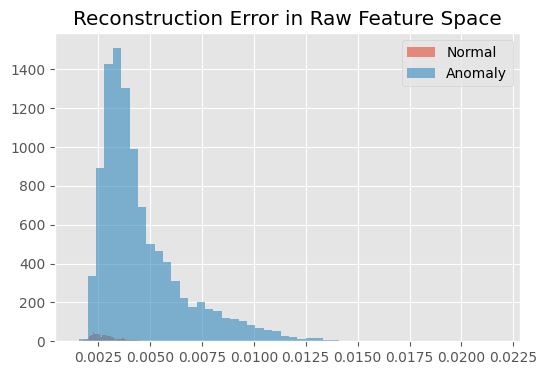

In [38]:
plt.hist(raw_mae_normal, bins=50, alpha=0.6, label="Normal")
plt.hist(raw_mae_anomaly, bins=50, alpha=0.6, label="Anomaly")
plt.legend()
plt.title("Reconstruction Error in Raw Feature Space")
plt.show()
